In [2]:
import pandas as pd
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from classes.pandas_api import APIPandas
import joblib

#Redability
rename = {
          'fullVisitorId':'UserId',
          'device.operatingSystem':'OS',
          'device.browser':'Browser',
          'device.deviceCategory':'DeviceType',
          'channelGrouping':'Channel',
          'weekend_prop':'%Weekend',
          'device.isMobile':'isMobile',
          'totals.hits':'Events',
          'totals.pageviews':'PageViews',
          'bounce_prop':'%Bounce',
          'trafficSource.medium':'Source'
          }

dataset = pd.read_csv('./data_customers.csv')
dataset = dataset.rename(columns=rename)
dataflow = APIPandas(dataset)

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.metrics import silhouette_score



from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans

data = dataflow.data
numeric_features = ['%Weekend', 'Events', 'PageViews', '%Bounce']
categorical_features = ['Channel', 'Browser', 'DeviceType', 'OS', 'Source','HourBins']

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', StandardScaler(), numeric_features),
        ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])
X = preprocessor.fit_transform(dataflow.data)
X = X.toarray()


In [4]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.009)
X_selected = selector.fit_transform(X)

original_feature_names = list(numeric_features) + list(preprocessor.named_transformers_['categorical'].get_feature_names_out(categorical_features))
removed_feature_indices = np.where(~selector.get_support())[0]
removed_features = [original_feature_names[i] for i in removed_feature_indices]
removed_features

['Channel_(Other)',
 'Channel_Affiliates',
 'Channel_Social',
 'Browser_Amazon Silk',
 'Browser_Android Webview',
 'Browser_Edge',
 'Browser_Opera',
 'Browser_Safari (in-app)',
 'OS_Windows Phone',
 'Source_affiliate']

Número óptimo de clusters (Codo): 14
Número óptimo de clusters (Calinski-Harabasz): 5
Número óptimo de clusters (Silhouette): 6
Silhouette Score para k=6: 0.214
Índice de Calinski-Harabasz para k=6: 1731.681


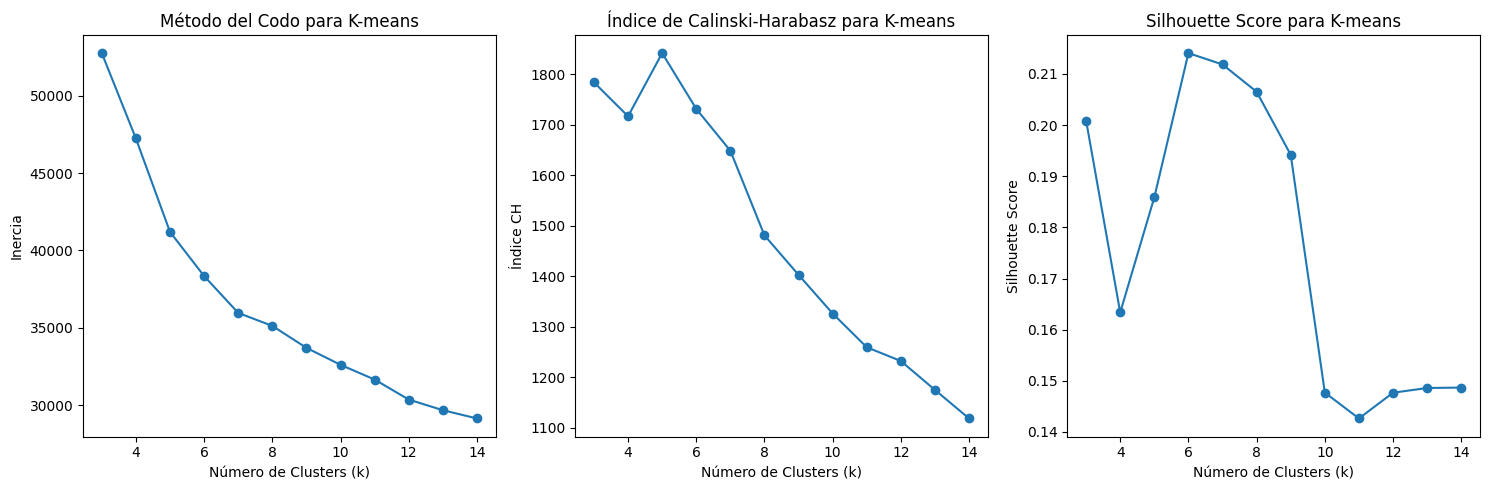

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

inertias = []
ch_scores = []
silhouette_scores = []
k_values = range(3, 15)  # Ajusta el rango de valores de k según tus necesidades

# Calcular métricas para cada valor de k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_selected)
    inertias.append(kmeans.inertia_)
    ch_scores.append(calinski_harabasz_score(X_selected, cluster_labels))
    silhouette_avg = silhouette_score(X_selected, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Encontrar el valor óptimo de k (considerando ambas métricas)
optimal_k_elbow = k_values[np.argmin(inertias)]  # Codo
optimal_k_ch = k_values[np.argmax(ch_scores)]    # Calinski-Harabasz
optimal_k_silhouette = k_values[np.argmax(silhouette_scores)]  # Silhouette


optimal_k = optimal_k_silhouette 


kmeans = KMeans(n_clusters=optimal_k, random_state=42) 
kmeans.fit(X_selected)

# joblib.dump(preprocessor, 'models/preprocessor.joblib')
# joblib.dump(selector, 'models/selector.joblib')
# joblib.dump(kmeans, 'models/kmeans_model.joblib')

# kmeans = KMeans(n_clusters=optimal_k, random_state=42)
# cluster_labels = kmeans.fit_predict(X_selected)


# Imprimir resultados
print(f"Número óptimo de clusters (Codo): {optimal_k_elbow}")
print(f"Número óptimo de clusters (Calinski-Harabasz): {optimal_k_ch}")
print(f"Número óptimo de clusters (Silhouette): {optimal_k_silhouette}")
print(f"Silhouette Score para k={optimal_k}: {silhouette_scores[optimal_k - k_values[0]]:.3f}")
print(f"Índice de Calinski-Harabasz para k={optimal_k}: {ch_scores[optimal_k - k_values[0]]:.3f}")


# Graficar las métricas
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Método del codo
axes[0].plot(k_values, inertias, marker='o')
axes[0].set_title("Método del Codo para K-means")
axes[0].set_xlabel("Número de Clusters (k)")
axes[0].set_ylabel("Inercia")

# Índice de Calinski-Harabasz
axes[1].plot(k_values, ch_scores, marker='o')
axes[1].set_title("Índice de Calinski-Harabasz para K-means")
axes[1].set_xlabel("Número de Clusters (k)")
axes[1].set_ylabel("Índice CH")

# Silhouette Score
axes[2].plot(k_values, silhouette_scores, marker='o')
axes[2].set_title("Silhouette Score para K-means")
axes[2].set_xlabel("Número de Clusters (k)")
axes[2].set_ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

Optimal Number of Clusters (BIC): 9


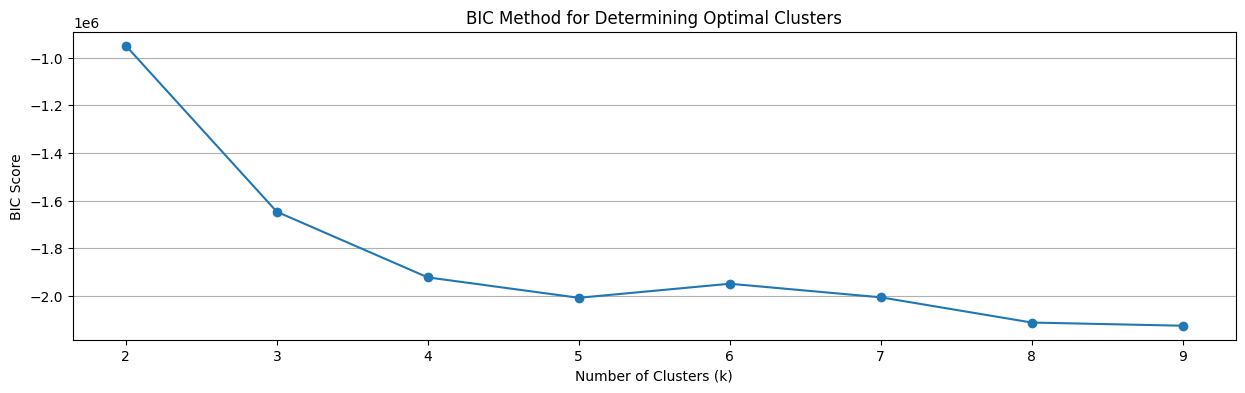

In [9]:
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt

k_values = range(2, 10)  
bic_scores = []

for k in k_values:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_selected)
    bic_scores.append(gmm.bic(X_selected))

optimal_k = k_values[np.argmin(bic_scores)] 

gmm_final = GaussianMixture(n_components=optimal_k, random_state=42)
gmm_final.fit(X_selected)
# joblib.dump(gmm_final, 'models/gmm_model.joblib')

print(f"Optimal Number of Clusters (BIC): {optimal_k}")

fig, ax = plt.subplots(figsize=(15, 4)) 
ax.plot(k_values, bic_scores, marker='o')
ax.set_title("BIC Method for Determining Optimal Clusters")
ax.set_xlabel("Number of Clusters (k)")
ax.set_ylabel("BIC Score")
ax.set_xticks(k_values)                
plt.grid(axis='y')                
plt.show()

In [7]:
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt

bandwidth = estimate_bandwidth(X_selected, quantile=0.3)

# Aplicar Mean Shift
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
cluster_labels = ms.fit_predict(X_selected)

# filename = 'models/meanshift_model.joblib' 
# joblib.dump(ms, filename)

n_clusters = len(np.unique(cluster_labels))
print(f"Número de clusters encontrados: {n_clusters}")

Número de clusters encontrados: 6


In [8]:
def predict_clusters(data):
    preprocessor = joblib.load('models/preprocessor.joblib')
    selector = joblib.load('models/selector.joblib')
    kmeans = joblib.load('models/kmeans_model.joblib')
    
    X = preprocessor.transform(data)
    X = X.toarray()
    X_selected = selector.transform(X)
    
    clusters = kmeans.predict(X_selected)
    
    data_clusters = data.copy()
    data_clusters['Cluster'] = clusters
    
    return data_clusters
prediction = predict_clusters(dataflow.data)

prediction


,UserId,Channel,%Weekend,hour,sessionId,Browser,DeviceType,isMobile,OS,Events,PageViews,%Bounce,Source,HourBins,Cluster
0,213131142648941,Direct,0.000000,22.0,1,Chrome,desktop,0.0,Macintosh,14.0,13.0,0.0,NaN,21:00-23:59,2
1,435324061339869,Referral,0.666667,21.0,3,Chrome,desktop,0.0,Macintosh,14.0,11.0,0.0,referral,21:00-23:59,3
2,562678147042735,Organic Search,0.000000,14.0,2,Chrome,desktop,0.0,Macintosh,12.5,10.5,0.0,organic,12:00-14:59,0
3,585708896049892,Referral,0.000000,20.0,1,Chrome,desktop,0.0,Linux,22.0,20.0,0.0,referral,18:00-20:59,1
4,670722016498267,Referral,0.000000,17.0,2,Chrome,desktop,0.0,Linux,9.5,9.5,0.0,referral,15:00-17:59,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9991,9991633376050110000,Social,0.000000,0.0,1,Chrome,desktop,0.0,Linux,17.0,16.0,0.0,referral,00:00-02:59,1
9992,9994767073213030000,Organic Search,0.000000,20.0,5,Chrome,desktop,0.0,Windows,42.0,30.0,0.0,organic,18:00-20:59,0
9993,9997409246962670000,Referral,0.000000,2.0,1,Chrome,desktop,0.0,Macintosh,86.0,65.0,0.0,referral,00:00-02:59,4
9994,9998597322098580000,Direct,0.000000,21.0,1,Chrome,desktop,0.0,Macintosh,37.0,33.0,0.0,NaN,21:00-23:59,2
